# Model 1: Base Specification

## Purpose: Explore the effect of COVID-19 Cases on Mobility Trends
### Based on the following model: 
\begin{align}
Mobility = \beta_0 + \beta_1 Weekly Net Case Change + \beta_2 Population + \beta_3 Income + \beta_4  Trump Support + \beta_5 PhaseOne + \beta_6 PhaseTwo + \beta_7 PhaseThree + \epsilon
\end{align}

* Linear Regression
* K Nearest Neighbors
* Decision Tree
* Random Forest
* Bagging

## Dependencies

In [1]:
## Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

## Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

## For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

## For evaluating our model's performance
import sklearn.metrics as m

## Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## For evaluating variable importance
from sklearn.inspection import permutation_importance

## For Partial Dependency
from pdpbox import pdp

## For Multiple Outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
## Read in analysis data
dta0 = pd.read_csv('data/build/build5_analysis_data.csv')

dta0.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,country_region_code,country_region,sub_region_1,...,delta_death04,delta_death05,delta_death06,weekly_delta_deaths,phase_1,phase_2,phase_3,Pop_2019,lag_cm,delta_cm
0,2020-03-17,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,NaN,NaN
1,2020-03-18,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-8.0,-7.0
2,2020-03-19,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-15.0,-1.0
3,2020-03-20,51001,Accomack,Eastern Shore,1,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-16.0,-1.0
4,2020-03-21,51001,Accomack,Eastern Shore,1,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-17.0,-7.0


In [3]:
## Specify y and X variables
y_var = ['retail_and_recreation_percent_change_from_baseline']

X_vars = ['weekly_delta_cases','Pop_2019','DP03_0062E','P_Republican','phase_1','phase_2','phase_3']

var = y_var + X_vars

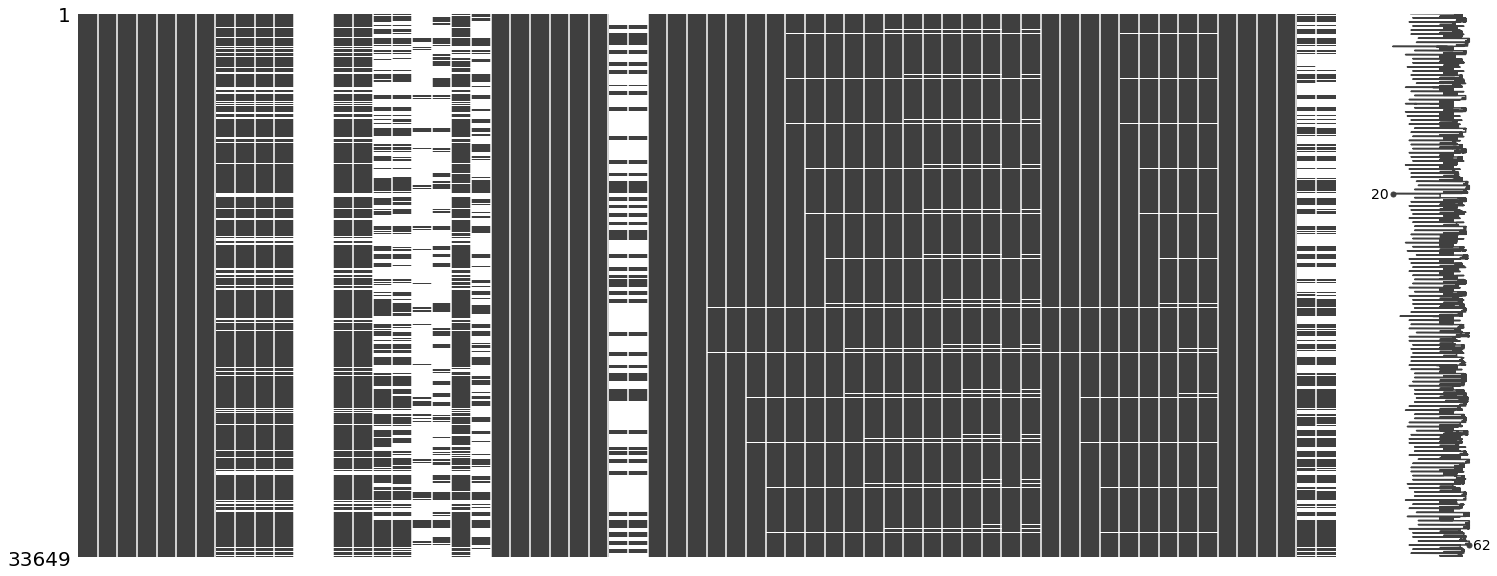

In [4]:
Viz_missing = miss.matrix(dta0)

In [5]:
## Check original count
dta0.shape

## Remove rows with missing values in variables of interest
dta1 = dta0.dropna(subset= var)

## Check count
dta1.shape

(33649, 64)

(17406, 64)

In [6]:
## Subset data into y and X
y = dta1[y_var]

X = dta1[X_vars]

## Split into training and test data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=12)

## Check dimensions of data
round(train_X.shape[0]/dta1.shape[0], 4)
train_X.shape[0]

round(test_X.shape[0]/dta1.shape[0], 4)

0.75

13054

0.25

<AxesSubplot:>

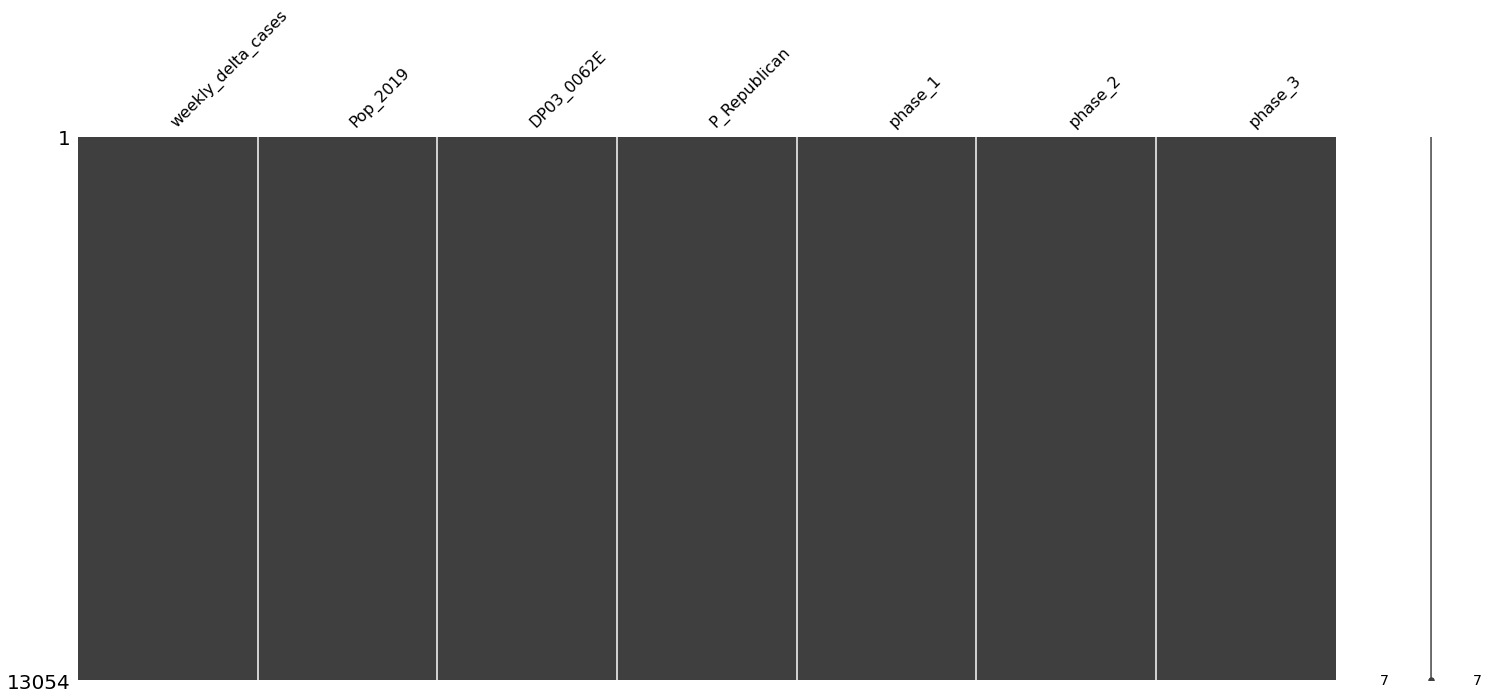

In [7]:
## Check for missing values in training data
miss.matrix(train_X)

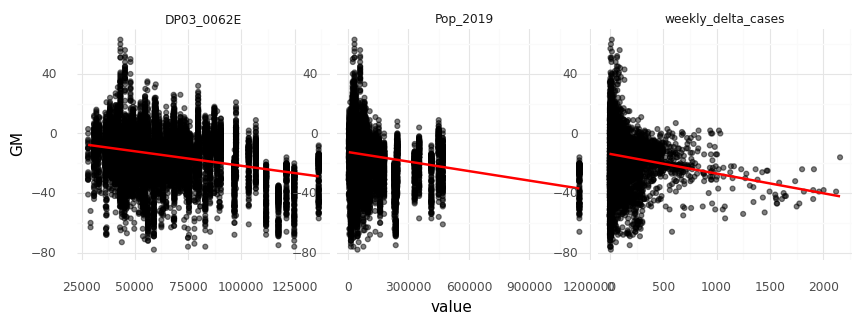

<ggplot: (180741946748)>

In [8]:
## Visualize distribution of continuous X variables against dependent variable
D = train_X[['weekly_delta_cases','Pop_2019','DP03_0062E']].copy()
D['GM'] = train_y


(
    ggplot(D.melt(id_vars=["GM"]),
           aes(x="value",y="GM"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [9]:
## Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=12)

## Set measurement specification
use_metrics = ["neg_mean_squared_error"]

## Compare statistical models with default parameters

In [10]:
## Linear Model
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [11]:
## KNN 
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [12]:
## Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

DecisionTreeRegressor(max_depth=3)

<Figure size 3600x2400 with 0 Axes>

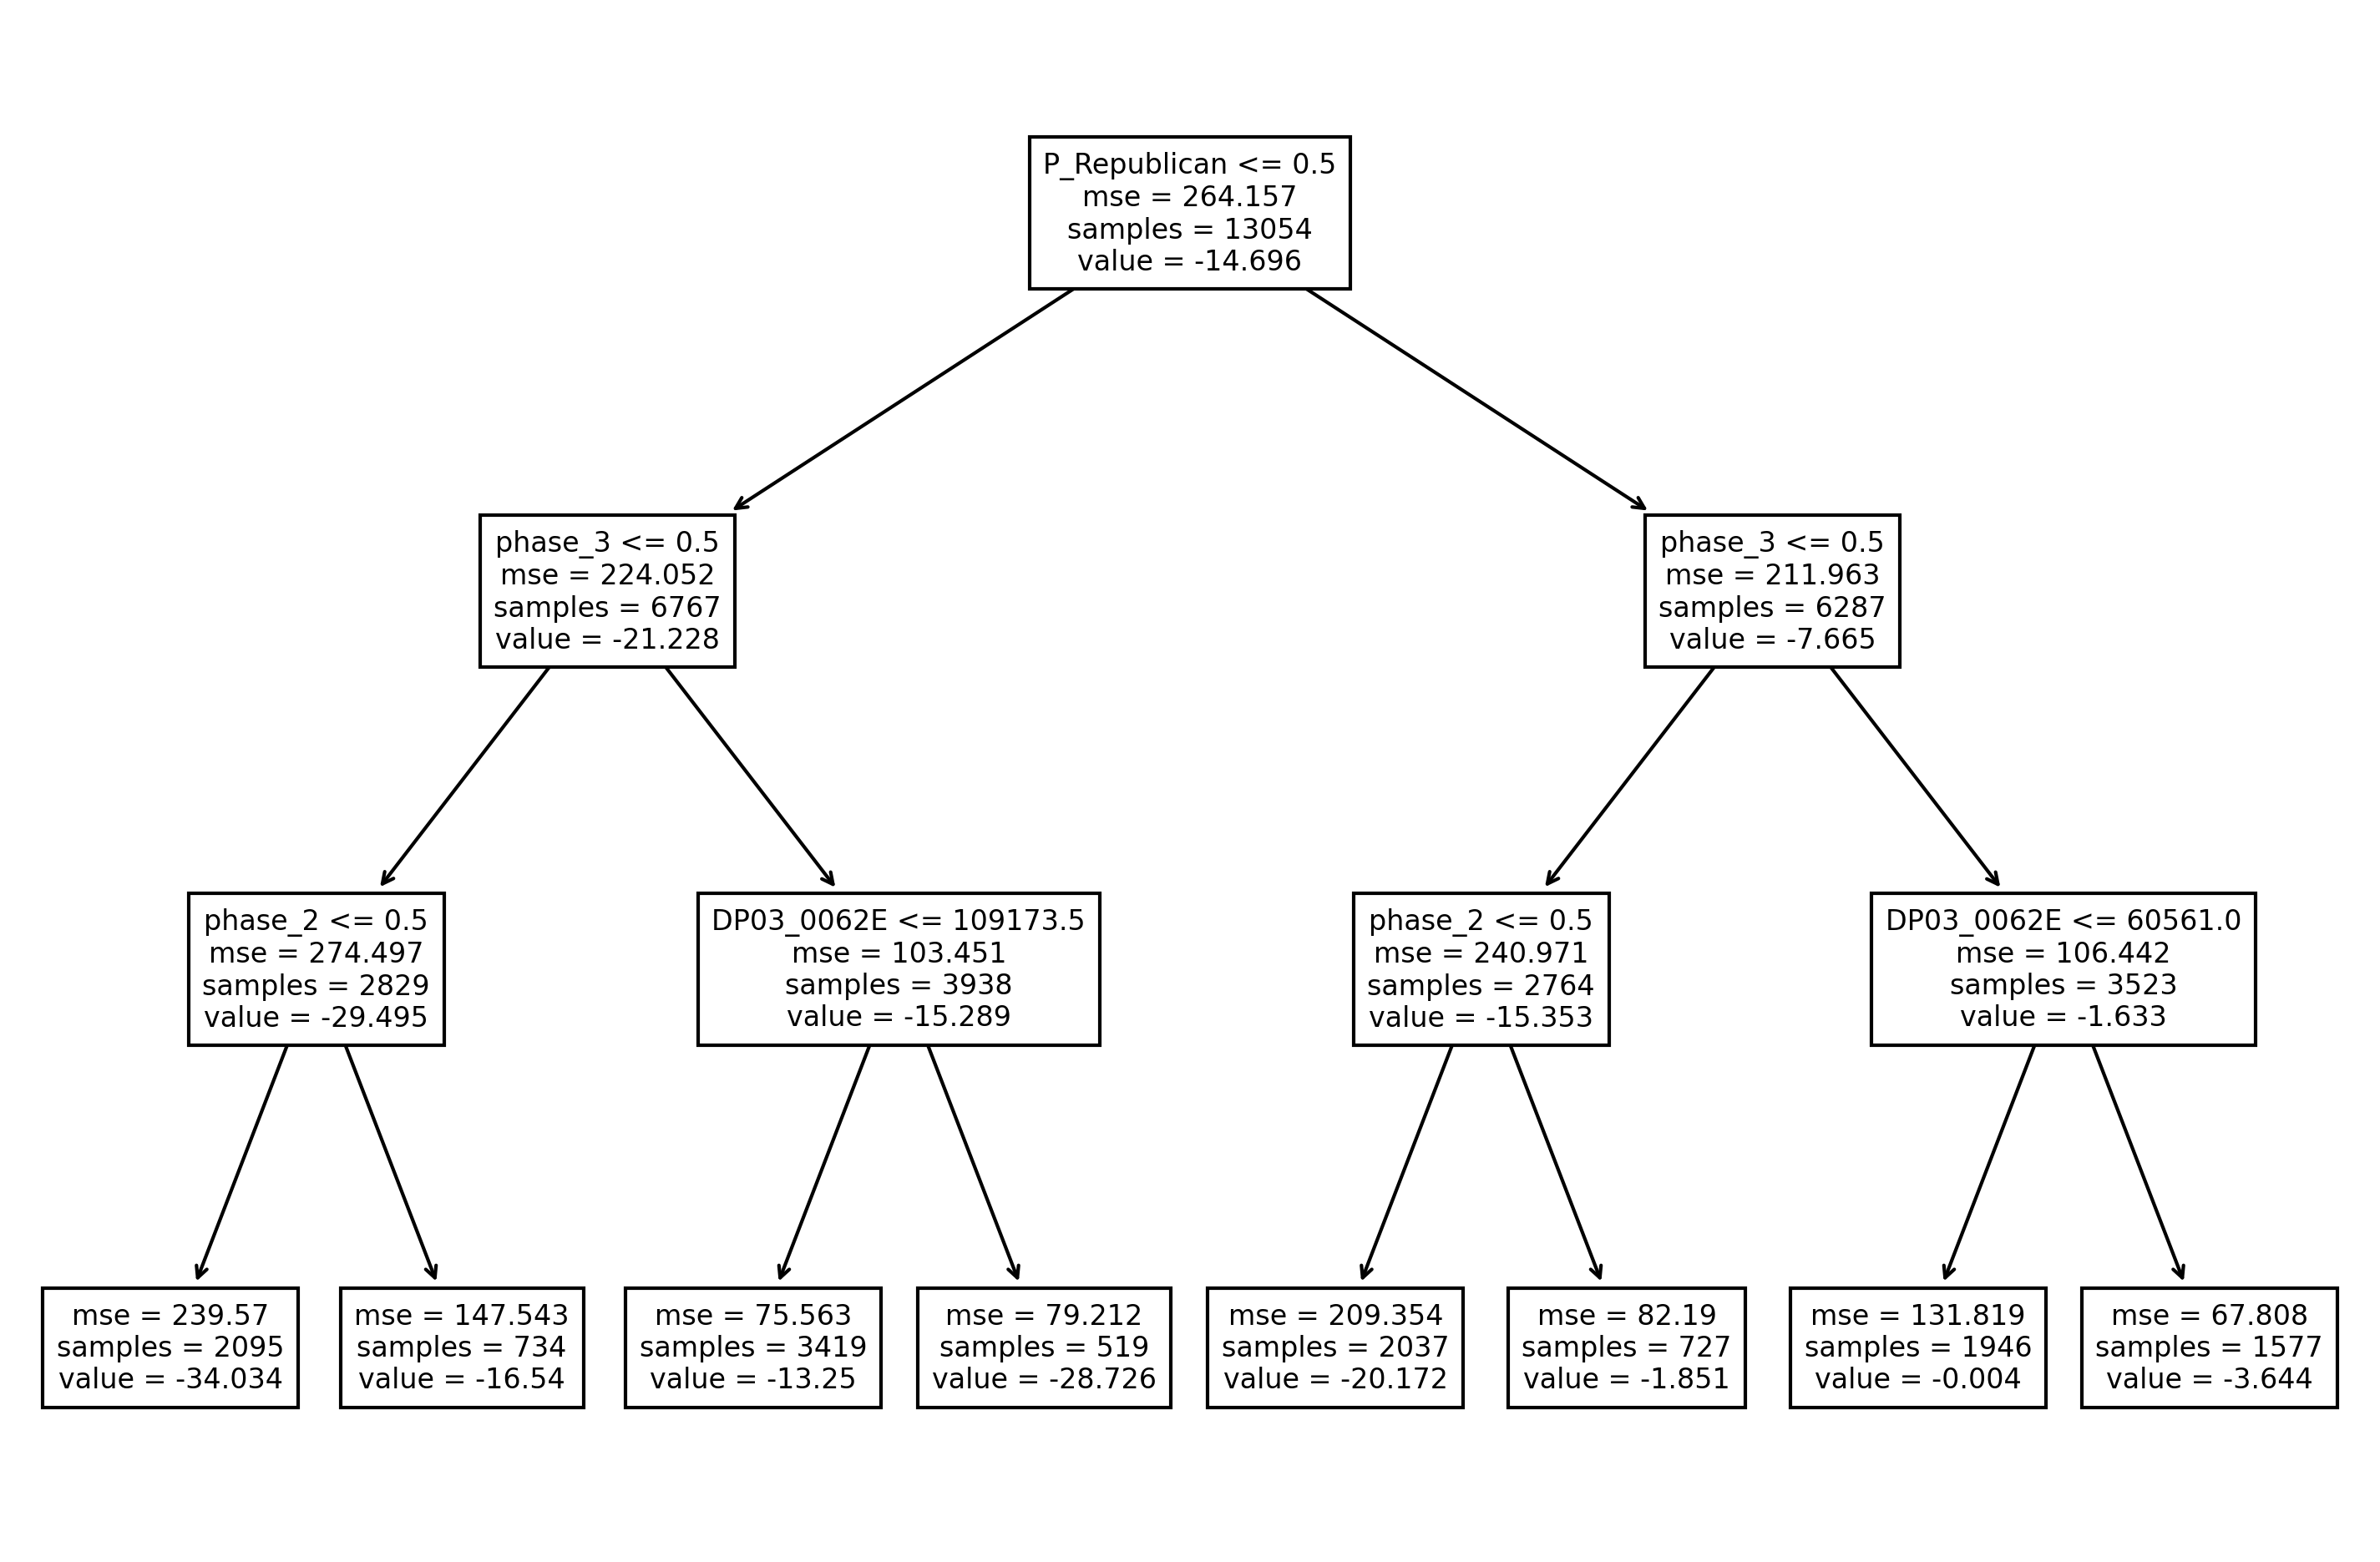

In [13]:
## Decision Tree Visualization
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = X_vars,fontsize=8)

In [14]:
## Bagging
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [15]:
## Random Forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Visualize performance of model

In [16]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(LM = lm_scores['test_neg_mean_squared_error']*-1,
     KNN = knn_scores['test_neg_mean_squared_error']*-1,
     DT = dt_scores['test_neg_mean_squared_error']*-1,
     BAG = bag_scores['test_neg_mean_squared_error']*-1,
     RF = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores["Model"] = collect_scores["Model"].str.replace("LM","Linear Model")
collect_scores["Model"] = collect_scores["Model"].str.replace("DT","Decision Tree")
collect_scores["Model"] = collect_scores["Model"].str.replace("BAG","Bagging")
collect_scores["Model"] = collect_scores["Model"].str.replace("RF","Random Forest")

collect_scores

,Model,MSE
0,Linear Model,131.735257
1,Linear Model,126.104371
2,Linear Model,124.446737
3,Linear Model,117.407933
4,Linear Model,129.470459
5,KNN,88.017495
6,KNN,91.226182
7,KNN,83.955833
8,KNN,86.871819
9,KNN,87.451172


In [17]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
Viz_MSE = (
    ggplot(collect_scores,
          aes(x="Model",y="MSE", fill= "Model")) +
    geom_boxplot() +
    # scale_y_discrete(labels= (["Linear Model","KNN","Decision Tree","Bagging","Random Forest"])) +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error", title= "MSE Comparison Between Statistical Models") +
    coord_flip() +
    theme_bw() +
    theme(panel_grid_major_y = element_blank(), panel_grid_minor_x = element_blank(), legend_position = "none") +
    theme(dpi=150)
)

Viz_MSE.save('data/figures/model1_MSE_Comparison')

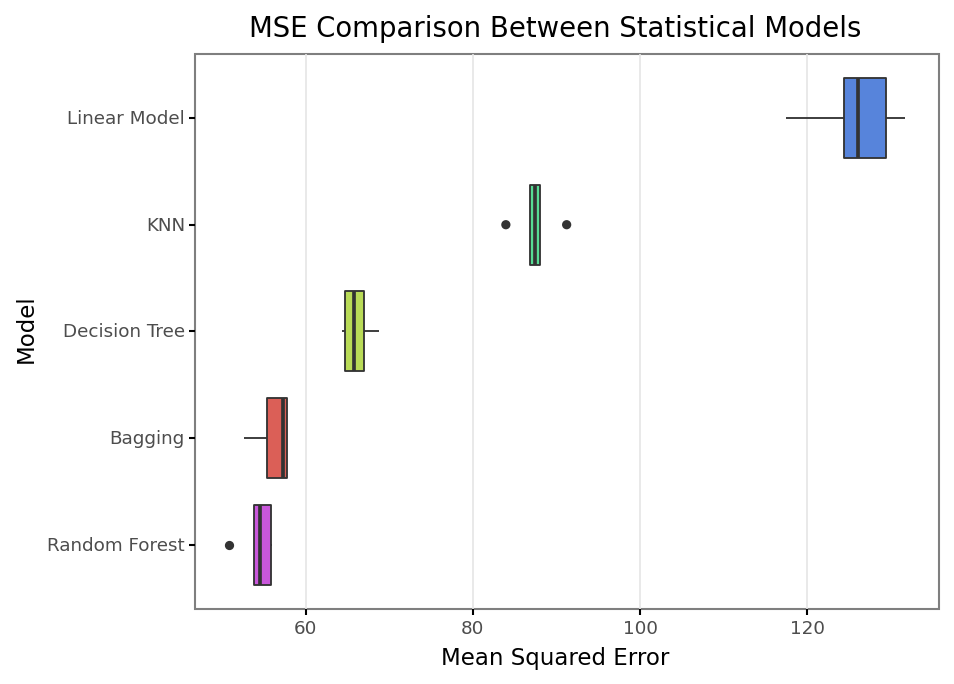

<ggplot: (180741938387)>

In [18]:
Viz_MSE

In [19]:
# Pipeline to compare all models

## Pre-Processing Specification
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), X_vars)])

## Model Pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

## Specify the models and their repsective tuning parameters.
search_space = [

    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


## Put it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['weekly_delta_cases',
                                                                          'Pop_2019',
                                                                          'DP03_0062E',
                                                                          'P_Republican',
                                                                          'phase_1',
                                                                          'phase_2',
                                                                          'phase_3'])])),
                                       ('model', None)]),
             n_jobs=4,
         

In [20]:
## Best Parameter
search.best_params_

## Best Score
search.best_score_ 

{'model': KNeighborsRegressor(n_neighbors=10), 'model__n_neighbors': 10}

-50.79065765703896

In [21]:
## Apply best model in prediction
pred_y = search.predict(test_X)

## Check MSE from Test X
m.mean_squared_error(test_y,pred_y)

46.93220358455883

In [22]:
## Create data frame of predictions and true value
pred = pd.DataFrame(pred_y)
compare = pd.concat([pred,test_y.reset_index(drop= True)], axis = 1).rename(columns={0: 'pred', 'retail_and_recreation_percent_change_from_baseline': 'truth'})

## Check data frame
compare.head()
compare.shape

,pred,truth
0,-27.1,-23.0
1,-31.0,-33.0
2,-12.2,-22.0
3,8.4,18.0
4,-9.8,-11.0


(4352, 2)

In [23]:
## Visualize true value vs predicted
Viz_TruePred= (
    ggplot(compare,
          aes(x="pred",y="truth")) +
    geom_point(alpha=.3, color= "darkblue") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    labs(x= "Predicted Value", y= "True Value", title= "True Value vs Predicted of Model 1\nKNN (10 Neighbors)") + 
    xlim(-80,80) + 
    ylim(-80,80) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Save out for report
Viz_TruePred.save('data/figures/model1_true_v_pred.png', dpi= 200)

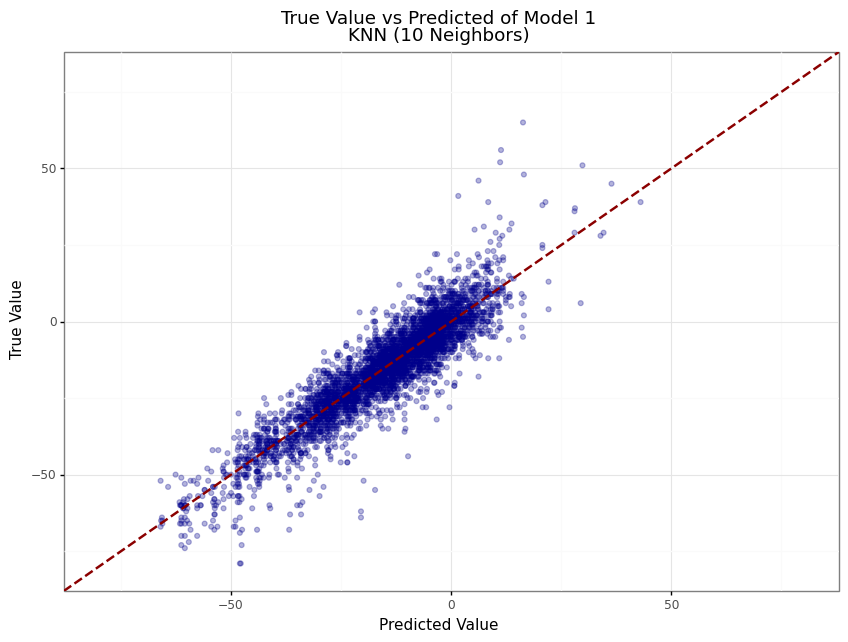

<ggplot: (180741876523)>

In [24]:
Viz_TruePred

In [25]:
## Set Best Estimator
knn10 = search.best_estimator_

In [26]:
## Evaluate Variable Importance with 25 runs
vi = permutation_importance(knn10,train_X,train_y,n_repeats=25)

In [27]:
# Organize as a data frame 
vi_dta = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dta['low'] = vi_dta['vi'] - 2*vi_dta['std']
vi_dta['high'] = vi_dta['vi'] + 2*vi_dta['std']

# But in order from most to least important
vi_dta = vi_dta.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dta

,variable,vi,std,low,high
0,phase_3,0.961029,0.011177,0.938676,0.983383
1,P_Republican,0.636236,0.011734,0.612768,0.659704
2,DP03_0062E,0.556970,0.009478,0.538015,0.575925
3,Pop_2019,0.322609,0.005236,0.312136,0.333082
4,phase_2,0.263463,0.006236,0.250991,0.275934
5,phase_1,0.202157,0.005376,0.191404,0.212910
6,weekly_delta_cases,0.129635,0.003996,0.121643,0.137628


In [28]:
## Visualize Variable Importance
Viz_VI= (
    ggplot(vi_dta,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.8, fill= "darkblue") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dta.variable.tolist(), labels= ['Phase 3', "Trump Support","Median Income", "Population","Phase 2","Weekly Net Case Change","Phase 1"]) +
    coord_flip() +
    labs(y="Reduction in AUC ROC", x="", title="Order of Variable Importance in Statistical Model\nModel 1") +
    theme(figure_size=(10,7)) +
    theme(panel_grid_major_y = element_blank(), panel_grid_minor_x = element_blank())
)

In [29]:
## Partial Dependency Plot
pdp_dist = pdp.pdp_isolate(model = knn10, 
                               dataset = train_X,
                               model_features = train_X.columns.tolist(),
                               feature='weekly_delta_cases',
                               num_grid_points=20)



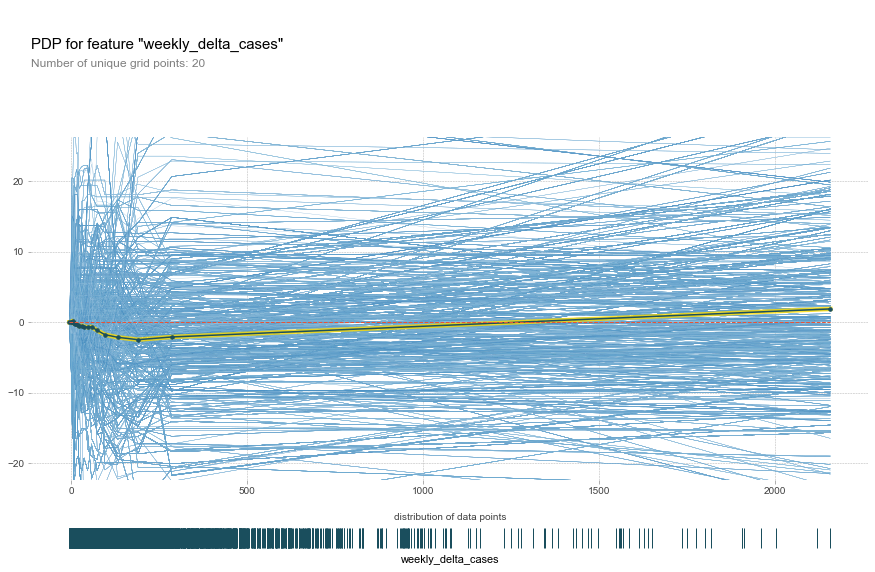

In [30]:
## Visualize ICE
Viz_ICE = pdp.pdp_plot(pdp_dist,'weekly_delta_cases',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

# Presentation Cells Below

# Community Mobility in Virginia During COVID-19
## Vince Egalla
### PPOL 564

# Goal: Measure the effect of COVID-19 on mobility to recreational locations

## Importance:
* This research may assist in improving state and local policy making decisions regarding COVID-19, especially the possible resurgence around the holiday season.
* Additionally, this research may assist business owners in terms of predicting customer turnout, influencing their decisions on logistics.

## Data Sources:
* Google Community Mobility Reports
* Virginia Department of Health
* U.S. Census
* Virginia Department of Elections
* Local News (CBS 19 News)

# General Model

## Dependent Variable:
* Google Community Mobility Trends on Retail and Recreation

## Defintion:

Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

Changes for each day are compared to a baseline, a median value corresponding to day of the week, during the 5-week period January 3rd – February 6, 2020.

## Concerns:
Baseline is established in Winter.

Data is missing when quality and privacy thresholds are not met.

Data is limited to users of Google Locations.

Noise is added to remove identifying information of a particular individual.


## Independent Variables:
* COVID-19 Cases Net Change in Past Week
* County Population
* County Median Income
* County Political Affiliation (Majority vote for Trump in 2020 election)
* State-wide Policy on Business Restrictions (Phase 1-3)

\begin{align}
Mobility = \beta_0 + \beta_1 Weekly Net Case Change + \beta_2 Population + \beta_3 Median Income + \beta_4 RepublicanSupport2020 + \beta_5 Phase1 + \beta_6 Phase2 + \beta_7 Phase3 +  \epsilon
\end{align}

## Observations: 17406

## Comparison of Models with Default Settings

### Train-Test Ratio: 75:25
### Cross Validation: K-Fold (5 folds)
### Comparison Statistic: Mean Squared Error (MSE)

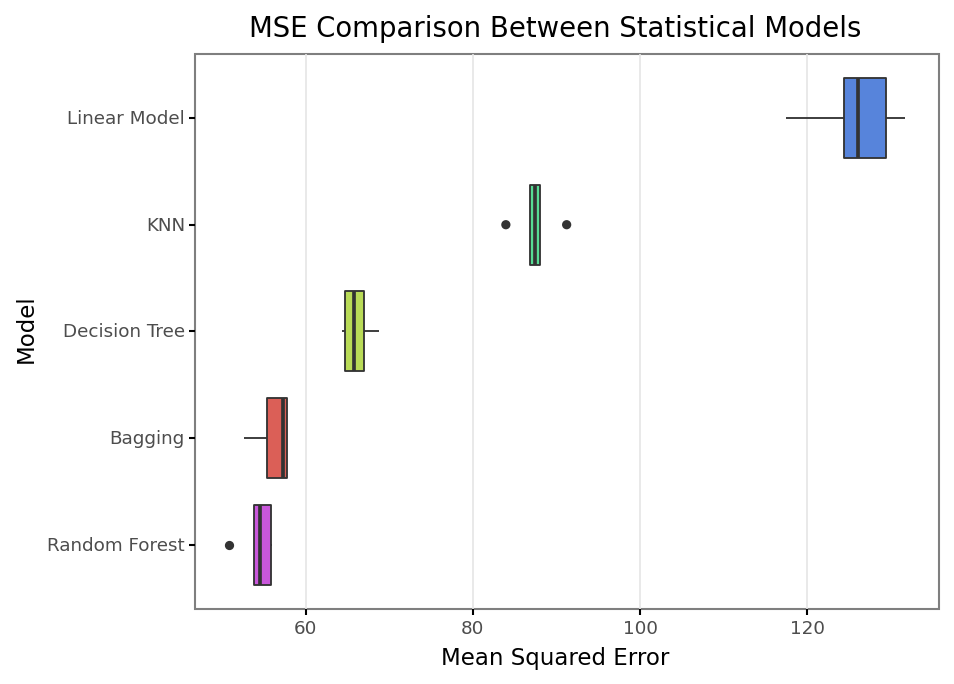

<ggplot: (180741938387)>

In [31]:
Viz_MSE

## Best Parameter for Prediction: KNN (10 Neighbors)
* 50.40 MSE

## Added Tuning Parameters:

### KNN:
Neighbors: 5, 10, 15, 20, 25

### Decision Tree:
Max Depth: 1, 2, 3, 4

### Random Forest:
Max Depth: 1, 2, 3

Estimators: 500, 1000, 1500

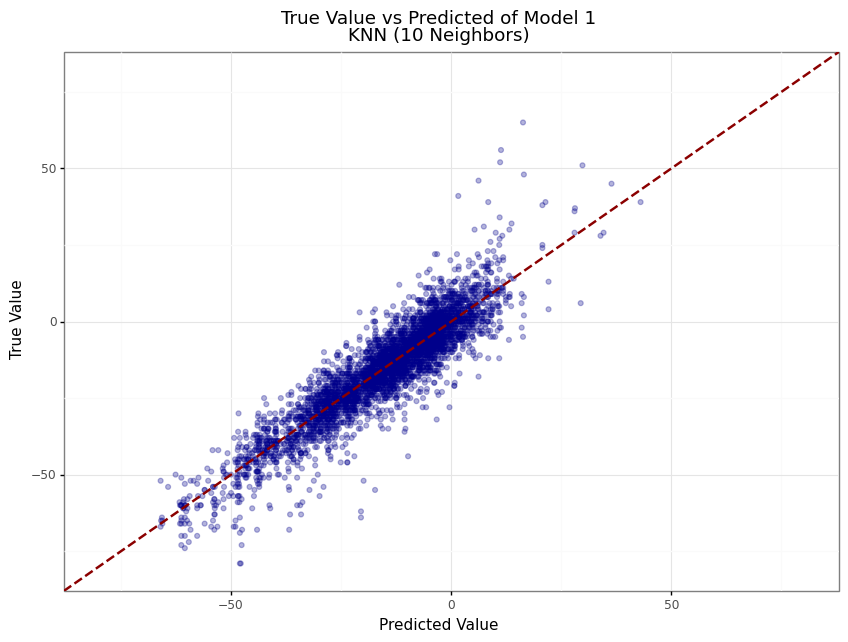

<ggplot: (180741876523)>

In [32]:
Viz_TruePred

## Variable Importance of KNN-10 Model

\begin{align}
Mobility = \beta_0 + \beta_1 Weekly Net Case Change + \beta_2 Population + \beta_3 Median Income + \beta_4 RepublicanSupport2020 + \beta_5 Phase1 + \beta_6 Phase2 + \beta_7 Phase3 +  \epsilon
\end{align}


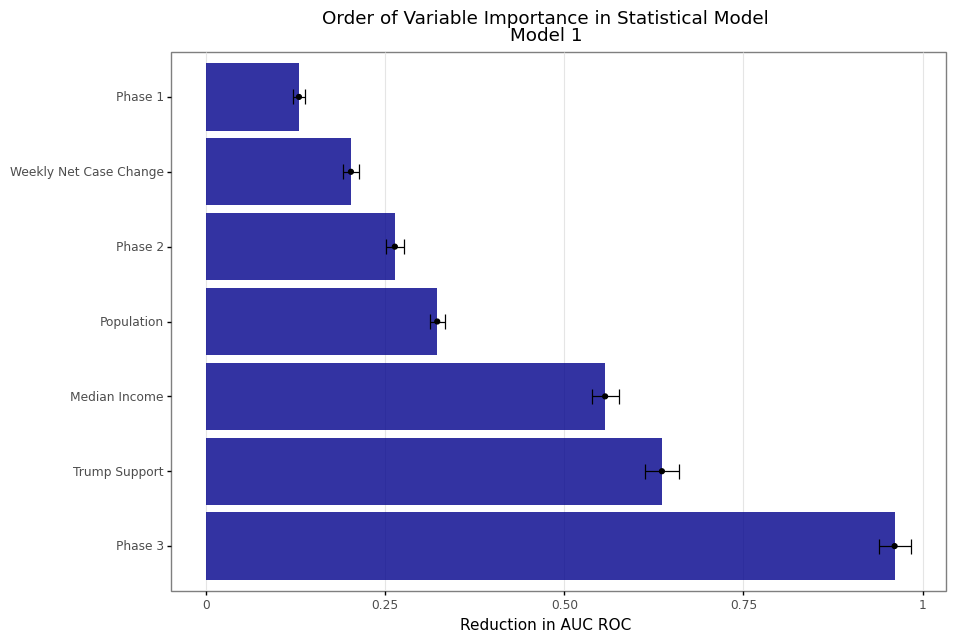

<ggplot: (180748582690)>

In [33]:
Viz_VI

## Partial Dependency Plot for Weekly Delta COVID-19 Cases

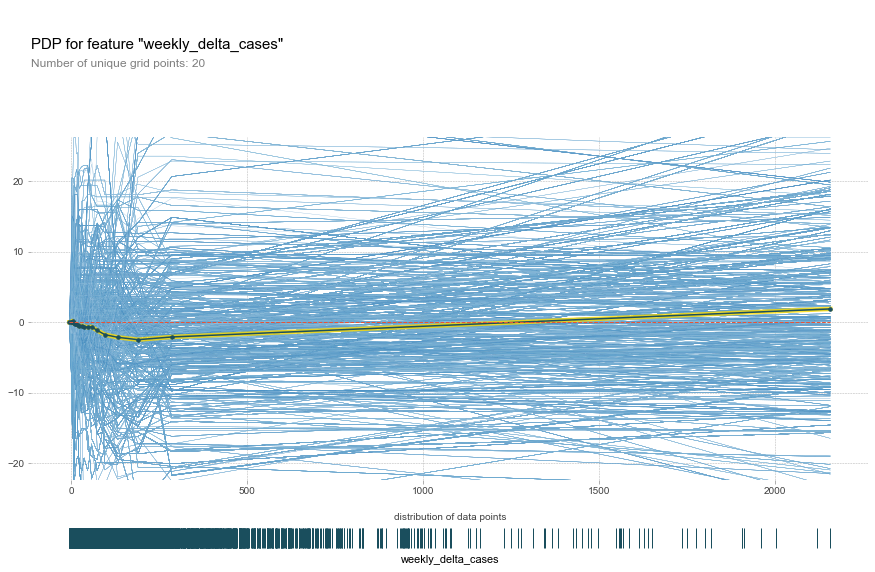

In [34]:
Viz_ICE = pdp.pdp_plot(pdp_dist,'weekly_delta_cases',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

## Conclusions:

### The most influential variables in this model are:
* Phase 3 (Lax State Wide Policy on Business Restrictions or Time)
* Support for Donald Trump
* Median Income

### Unfortunately, the change of COVID-19 cases within a week doesn't see overtly important in determining community mobility in Virginia...

### Considerations:
Phase 1 should represent the most restrictive policy on businesses, but is not important. I believe this indicates that rather than state policy being important, time (individuals grow accustomed to life under the pandemic in recent time) is more indicative as the phases are directly correlated to days.

## Looking Back:

### Challenges:
Review all data before attempting to merge together to reduce redundancy

Are there better ways to represent COVID 19 in the model?

## Going Forward:

### Alternative Specifications:
* Net Change in Hospitalizations or Deaths
* Precipitation
* Daily Fixed Effects
* County News of Local Outbreaks or Governor Announcements